Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# Fuel Performance

**Inputs**

- `fuel_dens`: Fuel density ($\frac{kg}{m^3}$)
- `porosity`: Porosity 
- `clad_thick`: Cladding thickness ($m$)
- `pellet_OD`: Pellet outer diameter ($m$)
- `pellet_h`: Pellet height ($m$)
- `gap_thick`: Gap thickness ($m$)
- `inlet_T`: Inlet temperature ($K$)
- `enrich`: U-235 enrichment
- `rough_fuel`: Fuel roughness ($m$)
- `rough_clad`: Clad rouchness ($m$)
- `ax_pow`: Axial power
- `clad_T`: Cladding surface temperature ($K$)
- `pressure`: Pressure ($Pa$)

**Outputs**

- `fis_gas_produced`: Fission gas production ($mol$)
- `max_fuel_centerline_temp`: Max fuel centerline temperature ($K$)
- `max_fuel_surface_temp`: Max fuel surface temperature ($K$)
- `radial_clad_dia`: Radial cladding diameter displacement after irradiation ($m$)

This data set consists of 13 inputs and 4 outputs with 400 data points. This data originates from [RK20](https://pymaise.readthedocs.io/en/stable/index.html#id3), and a graphical representation is provided in the figure below. Case 1 from the pellet-cladding mechanical interaction (PCMI) benchmark [1] was selected for the data set. This benchmark simulates a beginning of life (BOL) ramp of a 10-pellet pressurized water reactor (PWR) fuel rod to an average linear heat rate of $40~kW/m$. The inner and outer cladding diameters are reduced, so the fuel-clad interaction occurs during the ramp time. Axial power and rod surface temperature profiles were assumed to be uniform at $330^\circ C$. The 13 input parameters were uniformly randomly sampled independently within their uncertainty bounds and simulated in BISON. The rod response was recorded in 4 outputs.

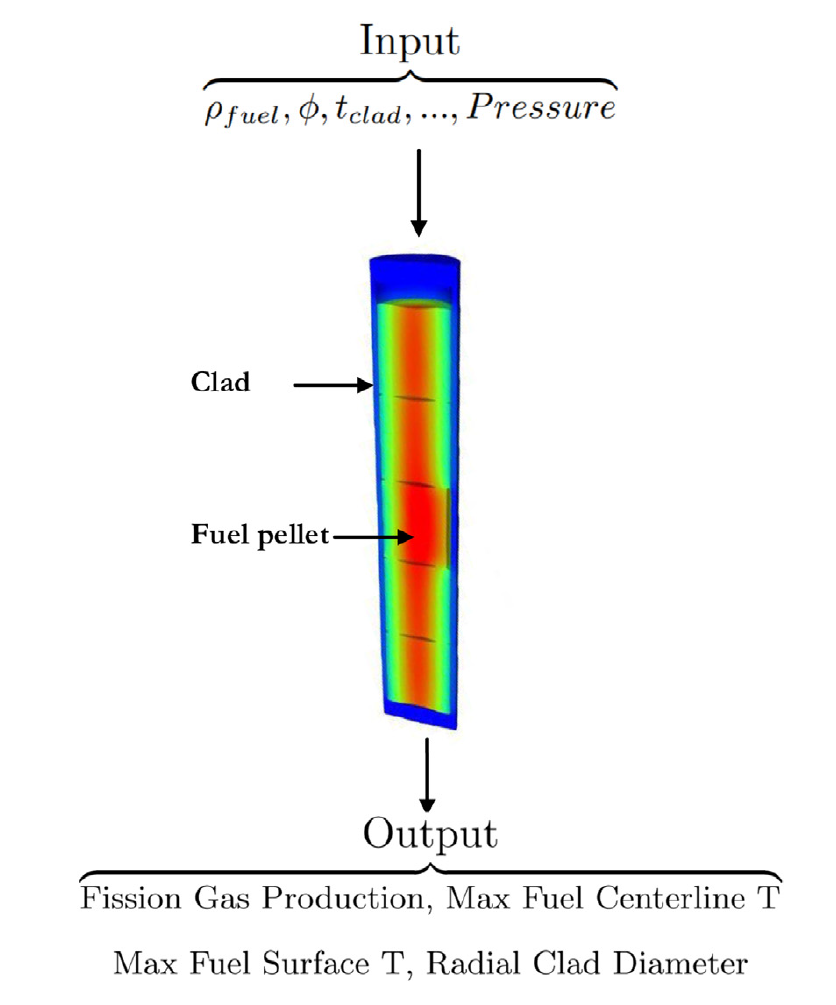


The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE specific functionality. 

In [26]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_fp
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We first start by initializing pyMAISE settings and then import the data set using `load_fp()` from the pyMAISE dataset library.

In [2]:
# Constructing pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data from repoisitory
data, inputs, outputs = load_fp()

As stated the data set consists of 13 inputs:

In [3]:
inputs

<xarray.DataArray (index: 400, variable: 13)>
array([[1.0466e+04, 4.0527e-02, 5.7110e-04, ..., 9.9967e-01, 6.0272e+02,
        1.5504e+07],
       [1.0488e+04, 4.1780e-02, 5.6984e-04, ..., 9.8741e-01, 6.0281e+02,
        1.5591e+07],
       [1.0434e+04, 5.8323e-02, 5.6760e-04, ..., 9.9225e-01, 6.2033e+02,
        1.5510e+07],
       ...,
       [1.0474e+04, 4.9933e-02, 5.6787e-04, ..., 9.7834e-01, 5.9643e+02,
        1.5645e+07],
       [1.0456e+04, 4.4766e-02, 5.7574e-04, ..., 9.5912e-01, 5.9159e+02,
        1.5441e+07],
       [1.0438e+04, 5.5806e-02, 5.7198e-04, ..., 9.9917e-01, 6.0763e+02,
        1.5379e+07]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fuel_dens' 'porosity' ... 'clad_T' 'pressure'

and 4 outputs with 400 total data points:

In [4]:
outputs

<xarray.DataArray (index: 400, variable: 4)>
array([[2.95000000e-05, 1.56969931e+03, 6.99613033e+02, 1.88000000e-05],
       [3.17000000e-05, 1.55946516e+03, 6.99976191e+02, 1.87000000e-05],
       [3.11000000e-05, 1.63239410e+03, 7.12771506e+02, 2.02000000e-05],
       ...,
       [3.04000000e-05, 1.55122859e+03, 6.92270857e+02, 1.81000000e-05],
       [3.09000000e-05, 1.50301759e+03, 6.83481715e+02, 1.72000000e-05],
       [3.17000000e-05, 1.62006353e+03, 7.04130846e+02, 1.98000000e-05]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fis_gas_produced' ... 'radial_clad_dia'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

(<Figure size 800x800 with 2 Axes>, <AxesSubplot:>)

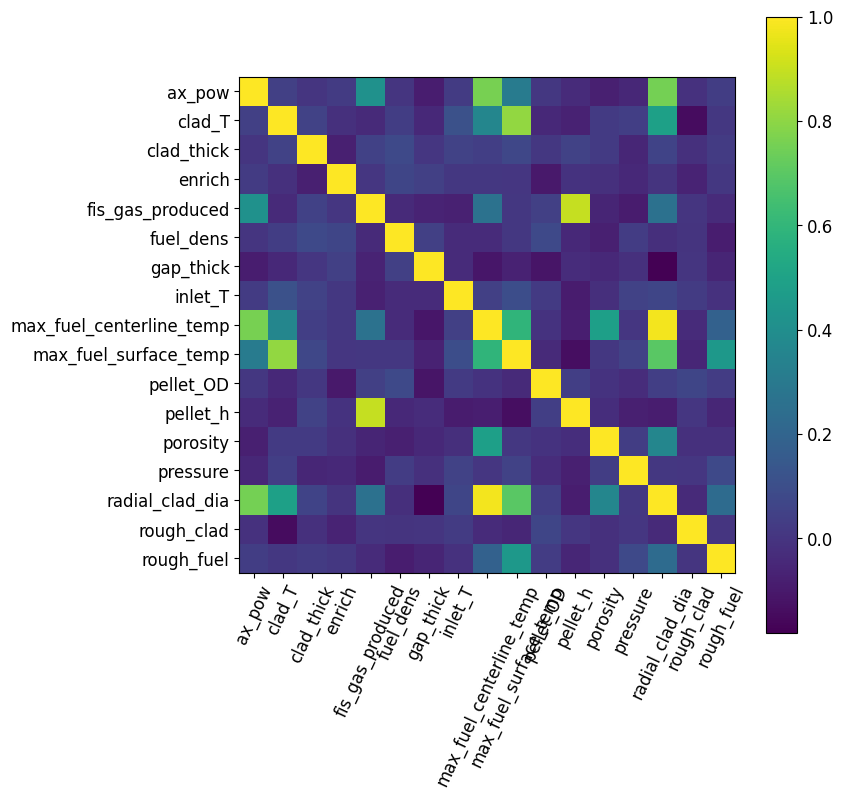

In [5]:
correlation_matrix(data)

There is a positive correlation between axial power and cladding temperature with max fuel centerline temperature, max fuel surface temperature, and radial cladding diameter. Additionally, the fission gas production correlates with pellet height.

The final step of the pyMAISE processing is splitting and data scaling. For this data set we will use min-max scaling.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyper-parameter tuning each model we must be initialized the archetecture and optimization search spaces.

In [7]:
# Initializing all the models wanted along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

We will use random search for the hyper-parameter tuning of the classical models (`Lasso`, `DT`, `RF`, and `KN`) through the `random_search` function. `Linear` will be manually fit with the Scikit-learn defaults. For each classical model 300 models will be produced with randomly sampled parameter configurations. For `nn`, bayesian search is used to optimize the hyper-parameters in 50 iterations through the `bayesian_search` function. Bayesian search is appealing for `nn` as their training can be computationally expensive. To further reduce the computational cost of `nn` we specify only 10 epochs which will produce less than performant models but show the optimal parameters. For both search methods we use cross-validation to reduce bias in the models from the data set. The hyper-parameter search spaces are defined in the `random_search_spaces` and `bayesian_search_spaces` dictionaries.

In [8]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 13s]
r2_score: 0.8333698050636912

Best r2_score So Far: 0.9775713791831283
Total elapsed time: 00h 10m 54s
Hyperparameter tuning took 16.587792042891184 minutes to process.


We can understand the hyper-parameter tuning of Bayesian search from the convergence plot.

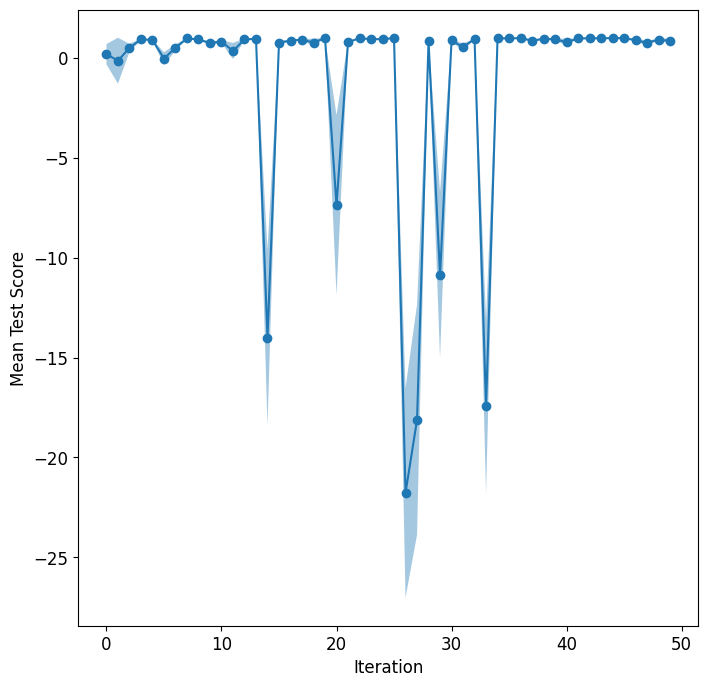

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuner.convergence_plot(model_types="FNN")

Fewer than 30 iterations were required to converge to the optimal parameter configurations.

## Model Post-processing

Now that the top `num_configs_saved` saved, we can pass these models to the `PostProcessor` for model comparison and analysis. To improve the `nn` performance we can pass an updated epochs parameter. Using 200 epochs should improve fitting at higher computational cost.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 200},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we will compute 4 metrics for both the training and testing data: 

In [11]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 163, 'Dense_input_0_su...",0.984572,0.850502,2.411074,1.552763,0.981294,0.909943,2.746068,1.657127
24,FNN,"{'Dense_input_0_units': 320, 'Dense_input_0_su...",0.985308,0.720193,1.870050,1.367498,0.980160,0.912677,2.926371,1.710664
25,FNN,"{'Dense_input_0_units': 292, 'Dense_input_0_su...",0.989448,0.658573,1.534525,1.238760,0.980073,0.903778,3.013466,1.735934
22,FNN,"{'Dense_input_0_units': 206, 'Dense_input_0_su...",0.984397,0.759843,1.680697,1.296417,0.979146,0.946418,2.633622,1.622844
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.979167,0.893934,2.209345,1.486387,0.978448,0.907572,2.386995,1.544990
1,Lasso,{'alpha': 0.00015763127353603717},0.978931,0.914103,2.302861,1.517518,0.978067,0.914398,2.518732,1.587051
2,Lasso,{'alpha': 0.0001709145587304184},0.978895,0.916510,2.315243,1.521592,0.978013,0.916365,2.534717,1.592080
3,Lasso,{'alpha': 0.00019399756009029116},0.978824,0.920784,2.339142,1.529425,0.977908,0.920179,2.564817,1.601504
4,Lasso,{'alpha': 0.00019427203741416836},0.978823,0.920837,2.339444,1.529524,0.977907,0.920226,2.565192,1.601622
5,Lasso,{'alpha': 0.00022903168060351304},0.978700,0.927706,2.381191,1.543111,0.977729,0.926830,2.616127,1.617444


Given the top performing models are `Linear` and `Lasso`, and `FN` this data set's outputs are linear with their inputs. `nn` also performs well for the linear data. Performance quickly drops off with `rforest`, `knn`, and `dtree`. We can look specifically at the performance for each output:

In [12]:
postprocessor.metrics(y="fis_gas_produced")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999247,3.328569e-08,1.681528e-15,4.100643e-08,0.999279,3.213842e-08,1.575071e-15,3.968716e-08
1,Lasso,{'alpha': 0.00015763127353603717},0.999174,3.393516e-08,1.844202e-15,4.294417e-08,0.999216,3.378223e-08,1.713022e-15,4.138867e-08
2,Lasso,{'alpha': 0.0001709145587304184},0.999165,3.404575e-08,1.865102e-15,4.318682e-08,0.999206,3.396850e-08,1.733192e-15,4.163163e-08
3,Lasso,{'alpha': 0.00019399756009029116},0.999147,3.426143e-08,1.905440e-15,4.365134e-08,0.999188,3.429218e-08,1.772297e-15,4.209866e-08
4,Lasso,{'alpha': 0.00019427203741416836},0.999147,3.426412e-08,1.905950e-15,4.365719e-08,0.999188,3.429603e-08,1.772793e-15,4.210455e-08
5,Lasso,{'alpha': 0.00022903168060351304},0.999115,3.464706e-08,1.976414e-15,4.445688e-08,0.999157,3.481078e-08,1.841480e-15,4.291247e-08
22,FNN,"{'Dense_input_0_units': 206, 'Dense_input_0_su...",0.998102,5.510035e-08,4.240466e-15,6.511886e-08,0.998015,5.422431e-08,4.333751e-15,6.583123e-08
21,FNN,"{'Dense_input_0_units': 163, 'Dense_input_0_su...",0.995840,8.643552e-08,9.292598e-15,9.639812e-08,0.995232,8.884528e-08,1.041052e-14,1.020320e-07
25,FNN,"{'Dense_input_0_units': 292, 'Dense_input_0_su...",0.995539,8.435496e-08,9.965992e-15,9.982981e-08,0.995100,8.700580e-08,1.069866e-14,1.034343e-07
24,FNN,"{'Dense_input_0_units': 320, 'Dense_input_0_su...",0.992570,1.198657e-07,1.659692e-14,1.288290e-07,0.991705,1.208560e-07,1.811351e-14,1.345864e-07


For fission gas production, decision tree out performs k-nearest neighbors. Additionally, fission gas production is well modeled by linear ML models (greater than 0.99 r-squared). The general exception to the outperformance to non-linear models is FN models.

In [13]:
postprocessor.metrics(y="max_fuel_centerline_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.997110,1.680697,4.153335,2.037973,0.996343,1.769332,4.963214,2.227827
1,Lasso,{'alpha': 0.00015763127353603717},0.996864,1.749543,4.506492,2.122850,0.995987,1.789235,5.446697,2.333816
2,Lasso,{'alpha': 0.0001709145587304184},0.996832,1.758051,4.552440,2.133645,0.995944,1.796536,5.504835,2.346239
3,Lasso,{'alpha': 0.00019399756009029116},0.996770,1.773198,4.641124,2.154327,0.995864,1.810814,5.614216,2.369434
4,Lasso,{'alpha': 0.00019427203741416836},0.996769,1.773389,4.642246,2.154587,0.995863,1.810990,5.615580,2.369721
5,Lasso,{'alpha': 0.00022903168060351304},0.996662,1.797935,4.797162,2.190242,0.995727,1.835016,5.800483,2.408419
22,FNN,"{'Dense_input_0_units': 206, 'Dense_input_0_su...",0.997690,1.483846,3.318898,1.821784,0.995400,1.954877,6.244237,2.498847
21,FNN,"{'Dense_input_0_units': 163, 'Dense_input_0_su...",0.995111,2.171362,7.024615,2.650399,0.994183,2.226280,7.895724,2.809933
24,FNN,"{'Dense_input_0_units': 320, 'Dense_input_0_su...",0.996632,1.656322,4.840241,2.200055,0.993889,2.186131,8.294663,2.880046
25,FNN,"{'Dense_input_0_units': 292, 'Dense_input_0_su...",0.997090,1.575562,4.181521,2.044877,0.993838,2.059782,8.363758,2.892016


The max fuel centerline temperature results closely follow the averaged results with decision tree back at the bottom.

In [14]:
postprocessor.metrics(y="max_fuel_surface_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 163, 'Dense_input_0_su...",0.957114,1.230644,2.619683,1.618543,0.947191,1.413493,3.088550,1.757427
24,FNN,"{'Dense_input_0_units': 320, 'Dense_input_0_su...",0.956782,1.224448,2.639961,1.624796,0.941680,1.464578,3.410823,1.846841
25,FNN,"{'Dense_input_0_units': 292, 'Dense_input_0_su...",0.967969,1.058728,1.956580,1.398778,0.936905,1.555330,3.690105,1.920965
23,FNN,"{'Dense_input_0_units': 226, 'Dense_input_0_su...",0.951400,1.441945,2.968725,1.722999,0.928358,1.737508,4.189969,2.046941
22,FNN,"{'Dense_input_0_units': 206, 'Dense_input_0_su...",0.944276,1.555524,3.403891,1.844964,0.926643,1.830795,4.290249,2.071292
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.923319,1.895041,4.684047,2.164266,0.921608,1.860956,4.584765,2.141206
1,Lasso,{'alpha': 0.00015763127353603717},0.922977,1.906871,4.704953,2.169090,0.920864,1.868357,4.628230,2.151332
2,Lasso,{'alpha': 0.0001709145587304184},0.922918,1.907990,4.708533,2.169915,0.920765,1.868922,4.634035,2.152681
3,Lasso,{'alpha': 0.00019399756009029116},0.922805,1.909936,4.715443,2.171507,0.920577,1.869903,4.645051,2.155238
4,Lasso,{'alpha': 0.00019427203741416836},0.922804,1.909959,4.715530,2.171527,0.920575,1.869915,4.645189,2.155270


The max fuel surface temperature is the output with the worst results for all models. All models struggle to predict this output with none predicting greater than 0.95 r-squared.

In [15]:
postprocessor.metrics(y="radial_clad_dia")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.996994,3.477091e-08,2.001327e-15,4.473620e-08,0.996564,3.618220e-08,2.108272e-15,4.591593e-08
22,FNN,"{'Dense_input_0_units': 206, 'Dense_input_0_su...",0.997521,3.206916e-08,1.650487e-15,4.062618e-08,0.996528,3.421297e-08,2.130564e-15,4.615803e-08
1,Lasso,{'alpha': 0.00015763127353603717},0.996710,3.648403e-08,2.190204e-15,4.679962e-08,0.996202,3.700761e-08,2.330179e-15,4.827193e-08
2,Lasso,{'alpha': 0.0001709145587304184},0.996663,3.674391e-08,2.221362e-15,4.713133e-08,0.996135,3.730607e-08,2.371670e-15,4.869980e-08
3,Lasso,{'alpha': 0.00019399756009029116},0.996573,3.721667e-08,2.281501e-15,4.776506e-08,0.996005,3.785839e-08,2.451533e-15,4.951296e-08
4,Lasso,{'alpha': 0.00019427203741416836},0.996572,3.722277e-08,2.282262e-15,4.777302e-08,0.996003,3.786513e-08,2.452542e-15,4.952315e-08
5,Lasso,{'alpha': 0.00022903168060351304},0.996417,3.803094e-08,2.385242e-15,4.883894e-08,0.995782,3.898879e-08,2.588093e-15,5.087330e-08
23,FNN,"{'Dense_input_0_units': 226, 'Dense_input_0_su...",0.997082,3.459696e-08,1.942994e-15,4.407941e-08,0.995380,3.872836e-08,2.834532e-15,5.324032e-08
25,FNN,"{'Dense_input_0_units': 292, 'Dense_input_0_su...",0.997194,3.431267e-08,1.867959e-15,4.321989e-08,0.994447,4.546712e-08,3.407090e-15,5.837028e-08
24,FNN,"{'Dense_input_0_units': 320, 'Dense_input_0_su...",0.995248,4.333863e-08,3.163639e-15,5.624623e-08,0.993367,5.161510e-08,4.070155e-15,6.379777e-08


The performance metrics for radial cladding diameter follow the averaged results.

We can see the parameters of each model with the best `Test R2` with `get_params`.

In [16]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00015763127353603717

Model Types: DT
max_depth: 18
max_features: 6
min_samples_leaf: 3
min_samples_split: 14

Model Types: RF
criterion: squared_error
max_features: 6
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 147

Model Types: KN
leaf_size: 1
n_neighbors: 7
p: 3
weights: distance

Model Types: FNN
Dense_input_0_units: 206
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5327424877062348
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0006947615471502126
Dense_hidden_0_units: 99
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.37874281698927775
batch_size: 8
Dense_hidden_1_units: 250
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.3796996673241373



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output. For the plots below we will do max fuel surface temperature.

With these plots we can see the narrow spread of `Linear`, `Lasso`, and `FNN` to $y = x$, the best possible performance of a model. Additionally, `KN` appears to be overfit to the training data set and the preditions of `FNN` under 700 K under-approximate the max fuel surface temperature. 

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each fuel centerline temperature prediction.

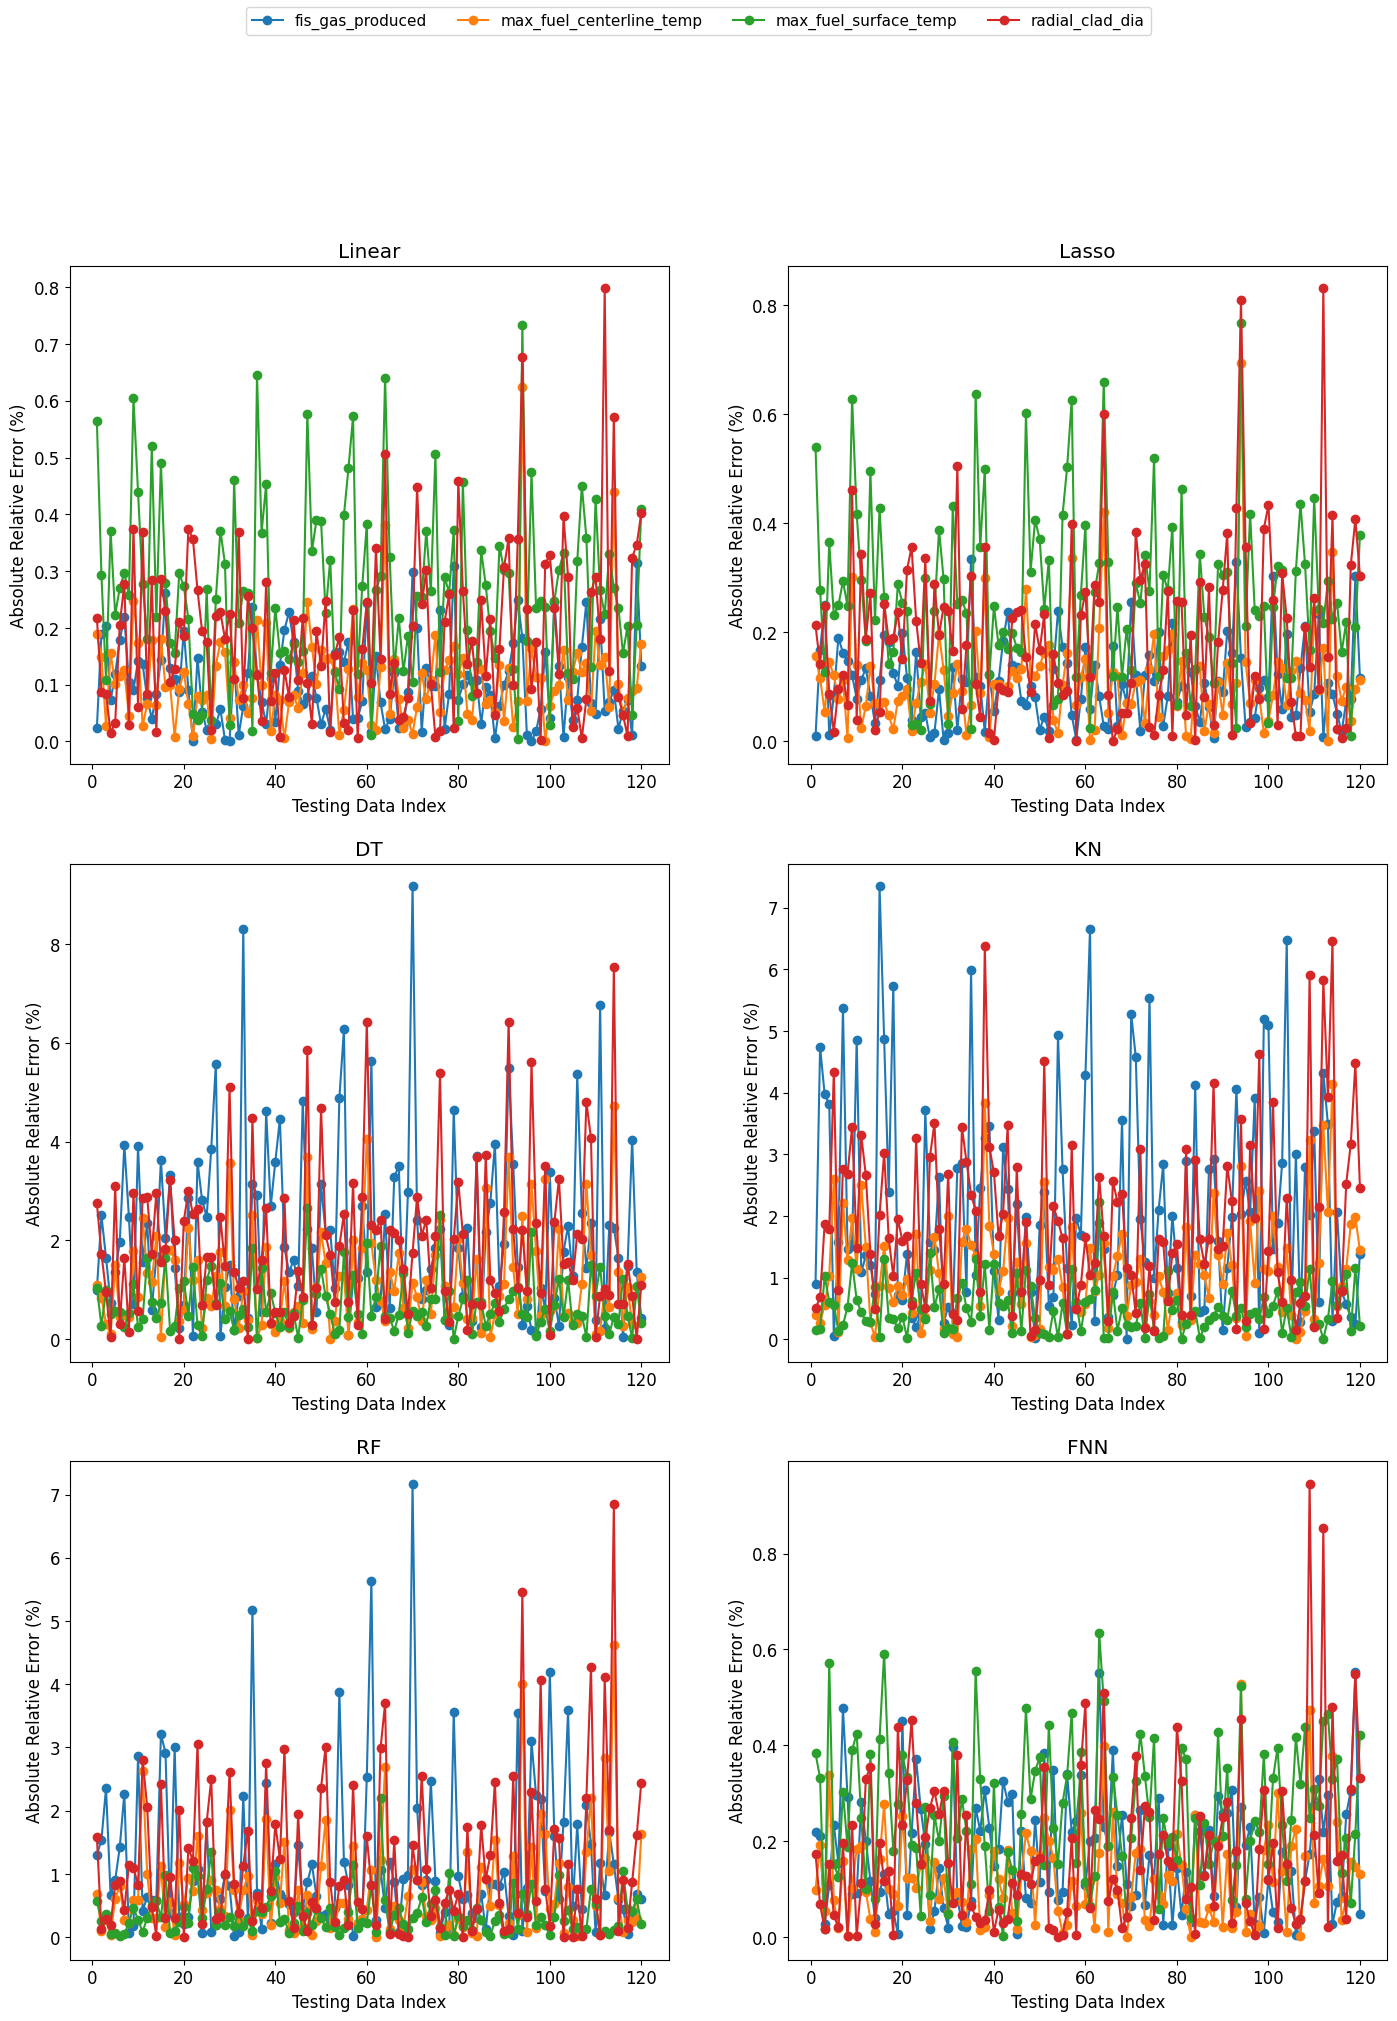

In [25]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
y = ["fis_gas_produced", "max_fuel_centerline_temp", "max_fuel_surface_temp", "radial_clad_dia"]

fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The performance gap of the linear model to the others is evident in the magnitude of the relative error. There is also one common outlier between `Linear`, `Lasso`, `DT`, and `RF` between 80 and 100. 

Finally, the learning curve of the most performant `FNN` is shown by `nn_learning_plot`.

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

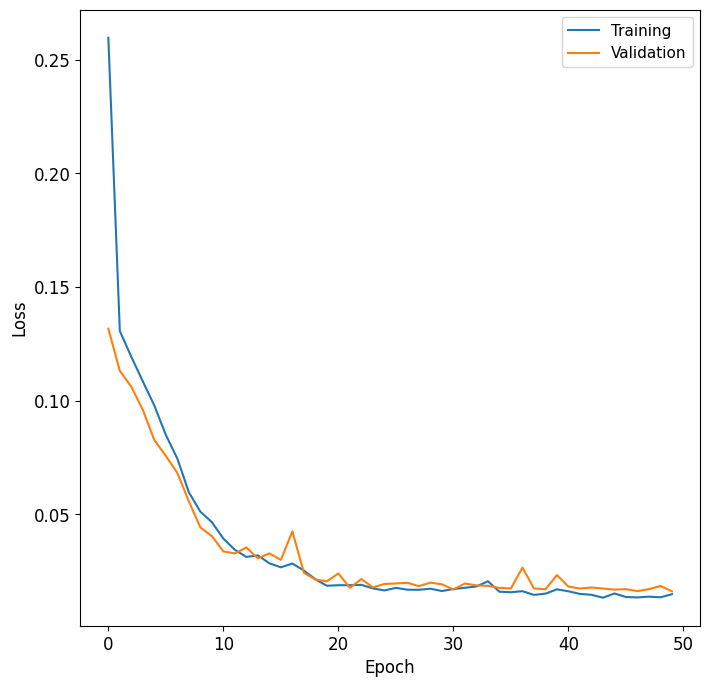

In [23]:
postprocessor.nn_learning_plot(model_type="FNN")

The validation curve is below the training curve; therefore, the best performing `nn` is not overfit. 

## References
1. Rossiter, G., Massara, S., & Amaya, M. (2016). OECD/NEA benchmark on pellet-clad mechanical interaction modelling with fuel performance codes (AECL-CW--124600-CONF-004). Canada

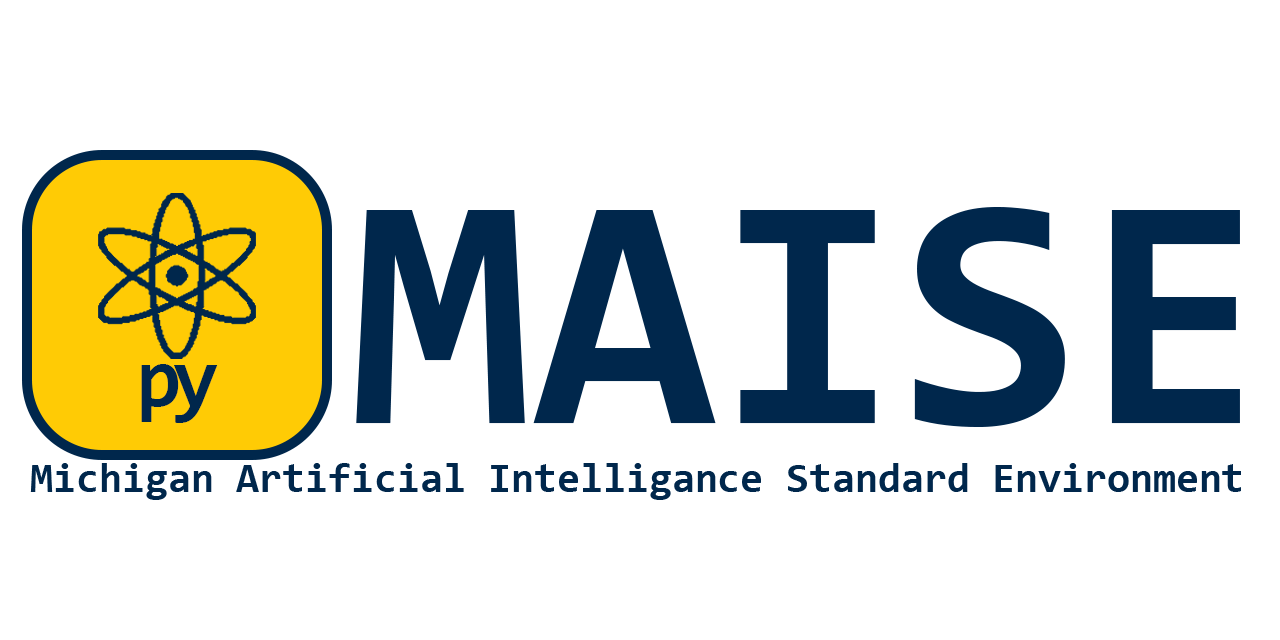